In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import torch
import torch.nn as nn
from tqdm.notebook import  tqdm
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.model_selection import train_test_split
import torchvision
import matplotlib.pyplot as plt
from IPython import display

import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

### Import and Inspect the Dataset

In [4]:
cdata = torchvision.datasets.EMNIST(root="emnist", split="letters", download=True)

100%|██████████████████████████████████████████████████████████████| 561753746/561753746 [00:42<00:00, 13277758.21it/s]


Extracting emnist\EMNIST\raw\gzip.zip to emnist\EMNIST\raw


In [7]:
print(f"All classes: {cdata.classes}")
print(f"Data size: {cdata.data.shape}")

# Transforming to 4D tensor for conv layers
images = cdata.data.view([124800, 1, 28, 28]).float()
print(f"Tensor shape: {images.shape}")

All classes: ['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Data size: torch.Size([124800, 28, 28])
Tensor shape: torch.Size([124800, 1, 28, 28])


In [6]:
torch.sum(cdata.targets == 0), len(torch.unique(cdata.targets))

(tensor(0), 26)

In [8]:
cdata.class_to_idx

{'N/A': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [9]:
import copy

letterCategories = cdata.classes[1:]
labels = copy.deepcopy(cdata.targets) - 1
print(labels.shape)
print(torch.sum(labels == 0))

torch.Size([124800])
tensor(4800)


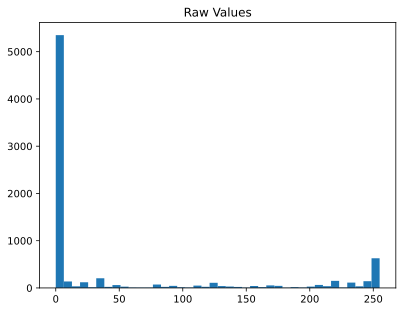

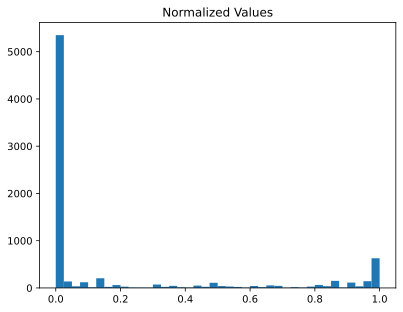

In [10]:
# Before normalizing
plt.hist(images[:10, :, :, :].view(1, -1).detach(), 40)
plt.title("Raw Values")
plt.show()

# Normalize
images /= torch.max(images)

# After normalizing
plt.hist(images[:10, :, :, :].view(1, -1).detach(), 40)
plt.title("Normalized Values")
plt.show()

### Visualize images

In [11]:
labels[100].item()

5

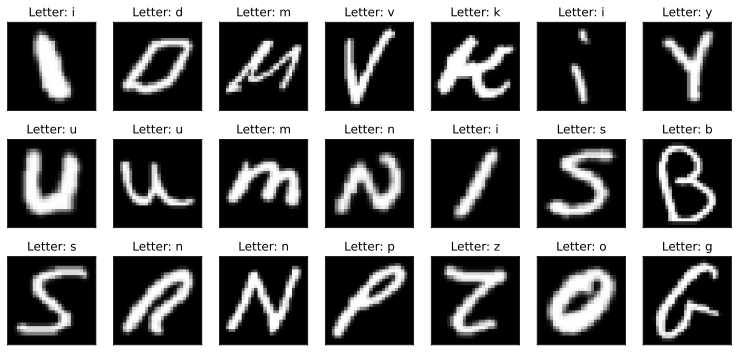

In [12]:
fig, axes = plt.subplots(3, 7, figsize=(13, 6))

for i , ax in enumerate(axes.flatten()):
    which_pic = np.random.randint(images.shape[0])

    image = images[which_pic, 0, :, :].detach()
    letter = letterCategories[labels[which_pic]]

    ax.imshow(image.T, cmap='gray')
    ax.set_title(f"Letter: {letter}")
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

### Train/Test Groups

In [13]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.01)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
batch_size = 128
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_dl = DataLoader(test_data, batch_size=len(test_data))

# DL Model

In [14]:
def make_the_model(print_toggle):
    class EMNISTNet(nn.Module):
        def __init__(self, print_toggle):
            super().__init__()
            self.print_toggle = print_toggle

            # Conv1
            self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
            self.bnorm1 = nn.BatchNorm2d(num_features=64)

            # Conv2
            self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
            self.bnorm2 = nn.BatchNorm2d(num_features=128) # Input: number of channels

            # Conv3
            self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
            self.bnorm3 = nn.BatchNorm2d(num_features=256) # Input: number of channels

            self.fc1 = nn.Linear(in_features=2*2*256, out_features=256)
            self.fc2 = nn.Linear(in_features=256, out_features=64)
            self.fc3 = nn.Linear(in_features=64, out_features=26)

        def forward(self, x):
            if self.print_toggle:
                print(f"Input: {list(x.shape)}")

            # First Block: conv -> max_pool -> bnorm -> relu
            x = F.max_pool2d(self.conv1(x), 2)
            x = F.leaky_relu((self.bnorm1(x)))
            x = F.dropout(x, p=0.25, training=self.training)
            if self.print_toggle:
                print(f"First Block: {list(x.shape)}")

            # Second Block: conv -> max_pool -> bnorm -> relu
            x = F.max_pool2d(self.conv2(x), 2)
            x = F.leaky_relu((self.bnorm2(x)))
            x = F.dropout(x, p=0.25, training=self.training)
            if self.print_toggle:
                print(f"Second Block: {list(x.shape)}")

            # Third Block: conv -> max_pool -> bnorm -> relu
            x = F.max_pool2d(self.conv3(x), 2)
            x = F.leaky_relu((self.bnorm3(x)))
            x = F.dropout(x, p=0.25, training=self.training)
            if self.print_toggle:
                print(f"Second Block: {list(x.shape)}")

            # Reshape for linear layer
            n_units = x.shape.numel() / x.shape[0]
            x = x.view(-1, int(n_units))
            if self.print_toggle:
                print(f"Vectorized: {list(x.shape)}")

            # Linear layers
            x = F.leaky_relu(self.fc1(x))
            x = F.dropout(x, p=0.5, training=self.training)
            x = F.leaky_relu(self.fc2(x))
            x = F.dropout(x, p=0.5, training=self.training)
            x = self.fc3(x)
            if self.print_toggle:
                print(f"Final Output: {list(x.shape)}")

            return x


    model = EMNISTNet(print_toggle)

    loss_fun = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

    return model, loss_fun, optimizer

In [15]:
model, loss_fun, optimizer = make_the_model(True)

X, y = next(iter(train_dl))

y_hat = model(X)
loss = loss_fun(y_hat, torch.squeeze(y))

print(f"Output: {y_hat.shape} | Loss: {loss.item()}")

Input: [128, 1, 28, 28]
First Block: [128, 64, 14, 14]
Second Block: [128, 128, 6, 6]
Second Block: [128, 256, 2, 2]
Vectorized: [128, 1024]
Final Output: [128, 26]
Output: torch.Size([128, 26]) | Loss: 3.303926467895508


### Function for training the model

In [16]:
def train_the_model():
    epochs = 10
    model, loss_fun, optimizer = make_the_model(False)

    model = model.to(device)

    train_loss = torch.zeros(epochs)
    test_loss = torch.zeros(epochs)
    train_acc = torch.zeros(epochs)
    test_acc = torch.zeros(epochs)

    for epoch_i in tqdm(range(epochs)):
        batch_loss = []
        batch_acc = []

        model.train()
        for X, y in tqdm(train_dl):
            X, y = X.to(device), y.to(device)

            y_hat = model(X)
            loss = loss_fun(y_hat, torch.squeeze(y))
            batch_loss.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item()
            batch_acc.append(acc)

        train_acc[epoch_i] = np.mean(batch_acc)
        train_loss[epoch_i] = np.mean(batch_loss)

        model.eval()
        X, y = next(iter(test_dl))
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            y_hat = model(X)
            loss = loss_fun(y_hat, torch.squeeze(y))
            acc = torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item()

            test_acc[epoch_i] = acc
            test_loss[epoch_i] = loss.item()

    return train_loss, test_loss, train_acc, test_acc, model

### Running the model

In [17]:
train_loss, test_loss, train_acc, test_acc, model = train_the_model()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/965 [00:00<?, ?it/s]

  0%|          | 0/965 [00:00<?, ?it/s]

  0%|          | 0/965 [00:00<?, ?it/s]

  0%|          | 0/965 [00:00<?, ?it/s]

  0%|          | 0/965 [00:00<?, ?it/s]

  0%|          | 0/965 [00:00<?, ?it/s]

  0%|          | 0/965 [00:00<?, ?it/s]

  0%|          | 0/965 [00:00<?, ?it/s]

  0%|          | 0/965 [00:00<?, ?it/s]

  0%|          | 0/965 [00:00<?, ?it/s]

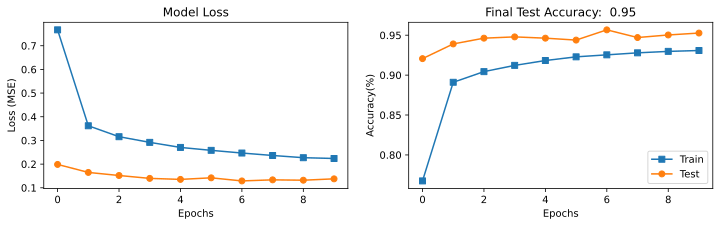

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

ax[0].plot(train_loss, "s-", label="Train")
ax[0].plot(test_loss, "o-", label="Test")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss (MSE)")
ax[0].set_title("Model Loss")

ax[1].plot(train_acc, "s-", label="Train")
ax[1].plot(test_acc, "o-", label="Test")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy(%)")
ax[1].set_title(f"Final Test Accuracy: {test_acc[-1]: 0.2f}")
ax[1].legend()
plt.show()

### Visualize some images

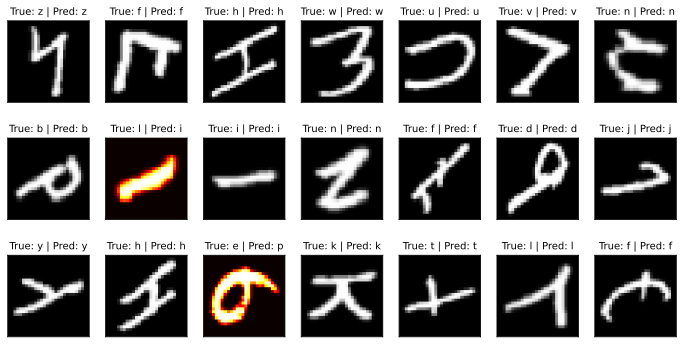

In [19]:
X, y = next(iter(test_dl))

X = X.to(device)
y = y.to(device)

y_hat = model(X)

rand_idx = np.random.choice(len(y), size=21, replace=False)

fg, axs = plt.subplots(3, 7, figsize=(12, 6))

for i, ax in enumerate(axs.flatten()):
    idx = rand_idx[i]
    image = np.squeeze(X[idx, 0, :, :]).cpu()
    true_letter = letterCategories[y[idx]]
    pred_letter = letterCategories[torch.argmax(y_hat, axis=1)[idx]]

    cmap = "gray" if true_letter == pred_letter else "hot"

    ax.imshow(image, cmap=cmap)
    ax.set_title(f"True: {true_letter} | Pred: {pred_letter}", fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

### Accuracy by letter

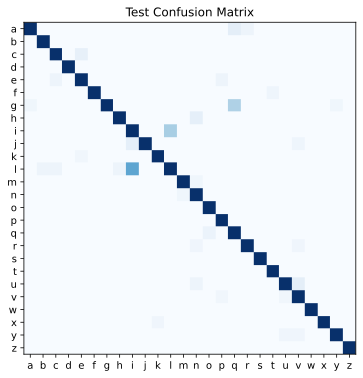

In [20]:
import sklearn.metrics as skm

C = skm.confusion_matrix(y.cpu(), torch.argmax(y_hat.cpu(), axis=1), normalize='true')

fig = plt.figure(figsize=(6, 6))
plt.imshow(C, "Blues", vmax=0.5)

plt.xticks(range(26), labels=letterCategories)
plt.yticks(range(26), labels=letterCategories)
plt.title("Test Confusion Matrix")
plt.show()